In [1]:
import math
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [81]:
class Value:
    def __init__(self, data, _children=(), _op='', label=''):
        self.data =  data
        #Grad will hold derivative for node with respect to L (Total function), initialized to 0 since it does not change the value of the node
        self.grad = 0.0
        self._backward = lambda: None
        self._prev = set(_children)
        self._op = _op
        self.label = label

    def __repr__(self):
        return f"Value(data={self.data})"
    
    def __add__(self, other):
        out = Value(self.data +  other.data, (self, other), '+')
        
        def _backward():
            self.grad += 1 * out.grad
            other.grad += 1 * out.grad

        out._backward = _backward
        return out
    
    def __mul__(self, other):
        out = Value(self.data *  other.data, (self, other),'*')
        
        def _backward():
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad
        out._backward = _backward    
        return out
    
    def tanh(self):
        x = self.data
        t= (math.exp(2*x)-1)/(math.exp(2*x)+1)
        out = Value(t, (self, ), 'tanh')

        def _backward():
            self.grad += (1 - t**2) * out.grad
            
        out._backward = _backward
        return out
    
    def backward(self):
        
        #Topological sort
        #A laying of a graph so that all edges go left to right
        topo = []
        visited = set()


        def build_topo(v):
            if v not in visited:
                #adds node to visited
                visited.add(v)
                #for each child of the node, in the tupple prev
                for child in v._prev:
                    #call the function recursively
                    build_topo(child)
                #append the node to the topological sort
                topo.append(v)

        #starts at root = LASTNODE = o (in our example)
        build_topo(self)
        self.grad = 1.0

        #We use topo to bacpropagate, in the correct order. Make sure all of its dependencias are defined.
        for node in reversed(topo):
            node._backward()


In [9]:
from graphviz import Digraph

def trace(root):
    #builds a set of all nodes and edges in graph
    nodes, edges = set(), set()
    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child, v))
                build(child)
    build(root)
    return nodes, edges

def draw_dot(root):
    dot = Digraph(format='svg', graph_attr={"rankdir":"LR"}) # LR - Left to right

    nodes, edges = trace(root)
    for n in nodes:
        uid = str(id(n))
        #for any value in the graph, create a rectangular (record node for it)
        dot.node(name=uid, label = "{%s | data %.4f | grad %.4f}" % (n.label, n.data, n.grad ), shape='record')
        if n._op:
            #if this value is a result of some opertation, crate a op node for it
            dot.node(name=uid + n._op, label = n._op)
            #and connect this node to it
            dot.edge(uid + n._op, uid)
    for n1, n2 in edges:
        #connect n1 to the op node of n2
        dot.edge(str(id(n1)), str(id(n2)) + n2._op)
    return dot   


In [84]:
#inputs x1, x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label="x2")
#weights
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
#bias
b = Value(6.8813735870195432, label='b')
#x1w1 + x2w2 + b
x1w1 = x1*w1; x1w1.label="x1w1"
x2w2 = x2*w2; x2w2.label="x1w1"
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1w1 + x2w2'
n = x1w1x2w2 + b; n.label = 'n'
#output
o =  n.tanh(); o.label='o'


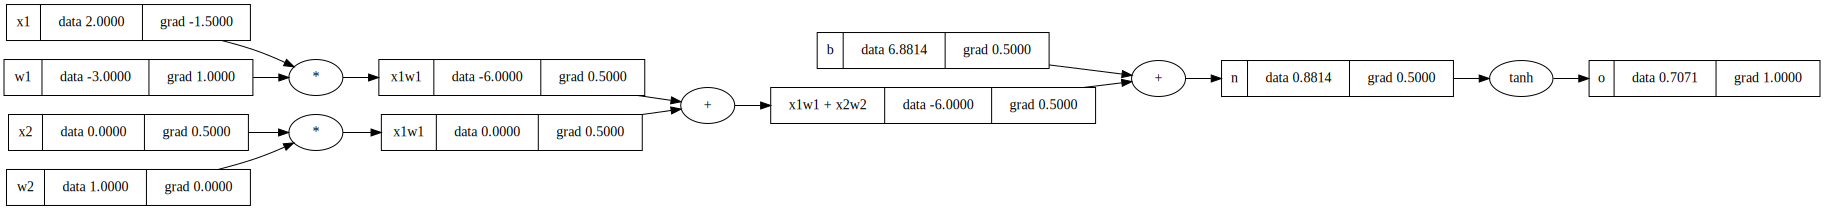

In [87]:
draw_dot(o)